In [1]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from scripts.charts import get_plot

GCP_PROJECT = 'opensource-observer'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../oso_gcp_credentials.json'
client = bigquery.Client(GCP_PROJECT)

In [2]:
pbc_query = """
    select distinct
      project_name,
      collection_name
    from `oso.projects_by_collection_v1`
"""

# pbc_query_result = client.query(pbc_query)
# df_pbc = pbc_query_result.to_dataframe()
# df_pbc.to_parquet('data/_local/projects_by_collection.parquet')

df_pbc = pd.read_parquet('data/_local/projects_by_collection.parquet')
df_pbc.tail(1)

,project_name,collection_name
5044,synapse,op-govgrants


In [3]:
pkg_query = """
    select distinct
      package,
      package_source,
      count(distinct artifact_namespace) as github_org_count
    from `ossd.sbom`
    group by 1,2
    order by 3
"""

# pkg_query_result = client.query(pkg_query)
# df_pkg = pkg_query_result.to_dataframe()
# df_pkg.to_parquet('data/_local/packages.parquet')

df_pkg = pd.read_parquet('data/_local/packages.parquet')
df_pkg.tail(1)

,package,package_source,github_org_count
85365,@types/node,NPM,1825


In [4]:
collections_list = [
    'optimism','op-govgrants', 'op-onchain',
    'op-rpgf1', 'op-rpgf2', 'op-rpgf3', 'op-retrofunding-4', 'op-retrofunding-5'
]
collections_str = "'" + "','".join(collections_list) + "'"

In [5]:
sbom_query = f"""
    select distinct
      abp.project_name,
      abp.artifact_namespace,
      abp.artifact_name,
      sbom.package,
      sbom.package_source
    from `ossd.sbom` as sbom
    join `oso.artifacts_by_project_v1` as abp
      on
        abp.artifact_namespace = lower(sbom.artifact_namespace)
        and abp.artifact_name = lower(sbom.artifact_name)
    join `oso.projects_by_collection_v1` as pbc
      on abp.project_name = pbc.project_name
    where
      abp.artifact_source = 'GITHUB'
      and pbc.collection_name in ({collections_str})
    order by project_name
"""

# sbom_query_result = client.query(sbom_query)
# df_sbom = sbom_query_result.to_dataframe()
# df_sbom.to_parquet('data/_local/op_sboms.parquet')

df_sbom = pd.read_parquet('data/_local/op_sboms.parquet')
df_sbom.tail(1)

,project_name,artifact_namespace,artifact_name,package,package_source
5695307,zwergdev-whale-bridge,zwergdev,whale-bridge,jsonfile,NPM


In [15]:
op_projects = list(
    df_pbc[
        df_pbc['collection_name'].isin(collections_list)
    ]['project_name'].unique()
)
print("Total OP-related projects on OSO:", len(op_projects))

op_projects = list(
    df_sbom[
        df_sbom['project_name'].isin(op_projects)
    ]['project_name'].unique()
)
print("OP projects with SBOMs:", len(op_projects))


print("\n***\n")

onchain_projects = list(
    df_pbc[
        df_pbc['collection_name'].isin(['op-onchain', 'op-retrofunding-4'])
    ]['project_name'].unique()
)
print("Total onchain projects on OSO:", len(onchain_projects))

onchain_projects = list(
    df_sbom[
        df_sbom['project_name'].isin(onchain_projects)
    ]['project_name'].unique()
)
print("Onchain projects with SBOMs:", len(onchain_projects))

Total OP-related projects on OSO: 724
OP projects with SBOMs: 638

***

Total onchain projects on OSO: 394
Onchain projects with SBOMs: 348


In [7]:
df = (
    df_pkg.set_index(['package_source', 'package'])
    .join(
        df_sbom
        .groupby(['package_source', 'package'])['project_name']
        .nunique()
        .rename('op_project_count')
    )
    .join(
        df_sbom[df_sbom.project_name.isin(onchain_projects)]
        .groupby(['package_source', 'package'])['project_name']
        .nunique()
        .rename('op_onchain_project_count')
    )
    .fillna(0)
    .reset_index()
)
df['op_project_share'] = df['op_project_count'].div(len(op_projects))
df['op_onchain_project_share'] = df['op_onchain_project_count'].div(len(onchain_projects))
df['ratio'] = df['op_onchain_project_share'] / df['op_project_share']
df

,package_source,package,github_org_count,op_project_count,op_onchain_project_count,op_project_share,op_onchain_project_share,ratio
0,GO,github.com/Ankr-network/dccn-tools/zap,1,1.0,0.0,0.001567,0.000000,0.000000
1,GO,github.com/kubernetes-csi/csi-test,1,0.0,0.0,0.000000,0.000000,NaN
2,GO,github.com/idena-network/idena-wasm-binding,1,0.0,0.0,0.000000,0.000000,NaN
3,GO,wallet,1,0.0,0.0,0.000000,0.000000,NaN
4,GO,github.com/filecoin-project/oni/lotus-soup,1,0.0,0.0,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...
85361,NPM,color-name,1790,547.0,316.0,0.857367,0.908046,1.059110
85362,NPM,ms,1790,547.0,316.0,0.857367,0.908046,1.059110
85363,NPM,debug,1792,547.0,316.0,0.857367,0.908046,1.059110
85364,NPM,inherits,1798,548.0,317.0,0.858934,0.910920,1.060523


Text(0, 0.5, '')

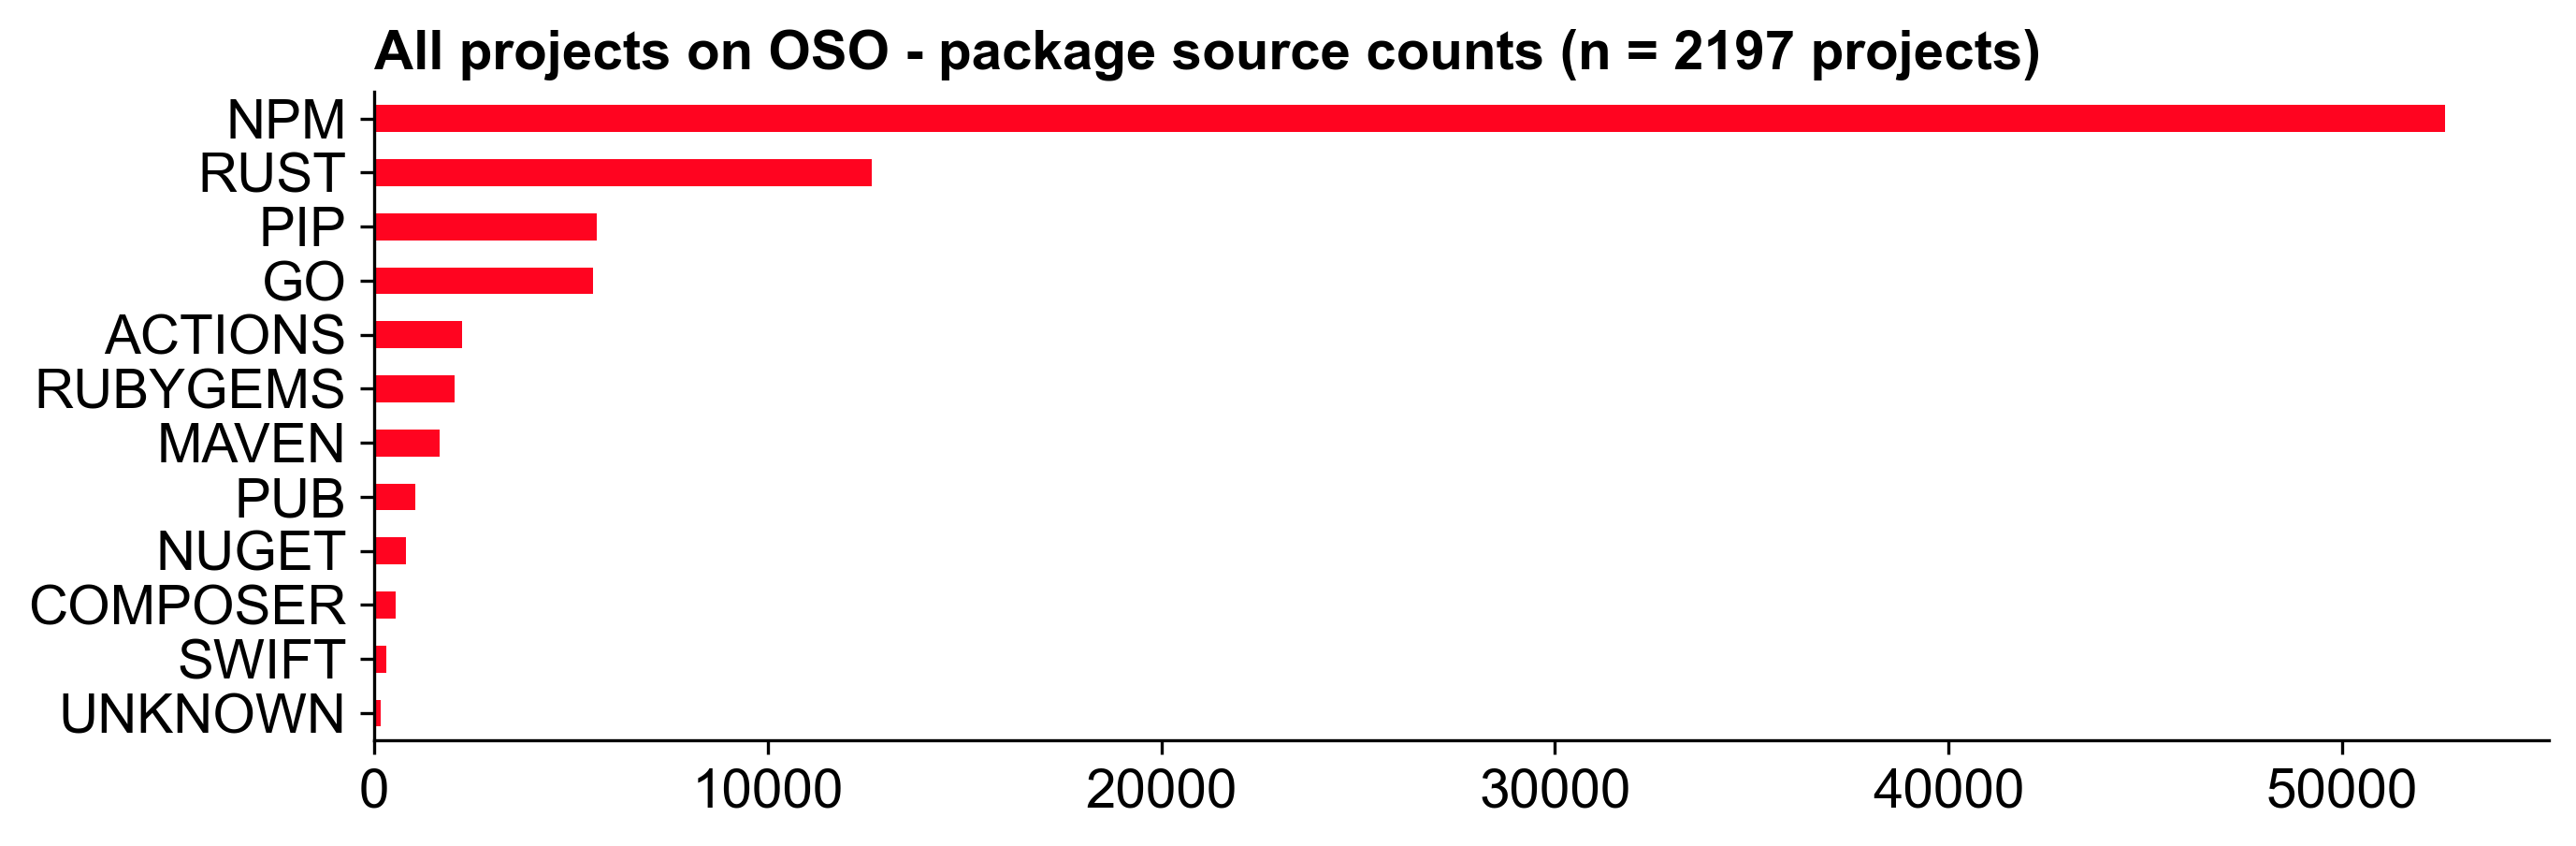

In [8]:
fig, ax = get_plot(
    df.groupby('package_source')['package']
    .nunique()
    .sort_values(),
    kind='barh',
    color='#FF0420'    
)
ax.set_title(f"All projects on OSO - package source counts (n = {df_pbc['project_name'].nunique()} projects)",
             loc='left', weight='bold')
ax.set_ylabel('')

Text(0, 0.5, '')

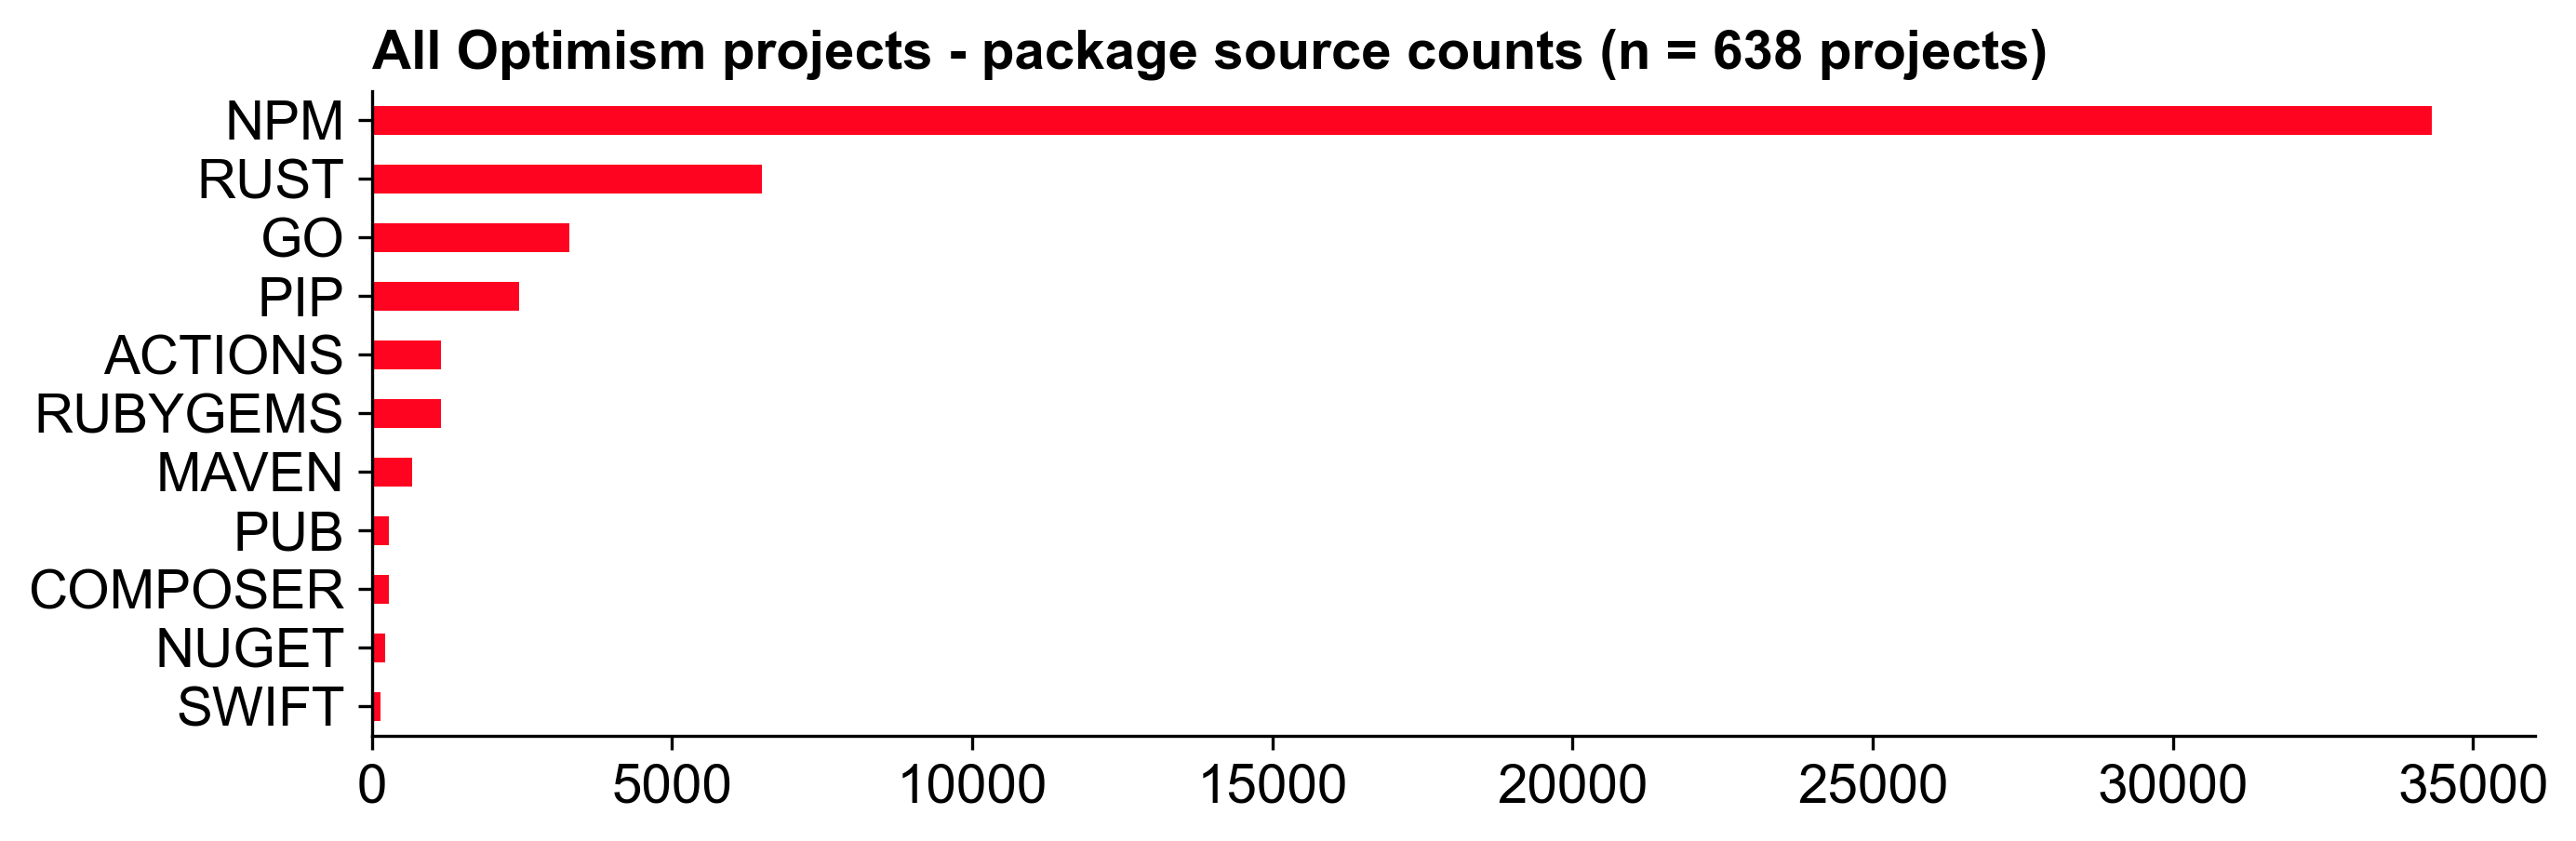

In [9]:
fig, ax = get_plot(
    df_sbom[
        df_sbom['project_name'].isin(op_projects)
    ].groupby('package_source')['package']
    .nunique()
    .sort_values(),
    kind='barh',
    color='#FF0420'    
)
ax.set_title(f'All Optimism projects - package source counts (n = {len(op_projects)} projects)',
             loc='left', weight='bold')
ax.set_ylabel('')

Text(0, 0.5, '')

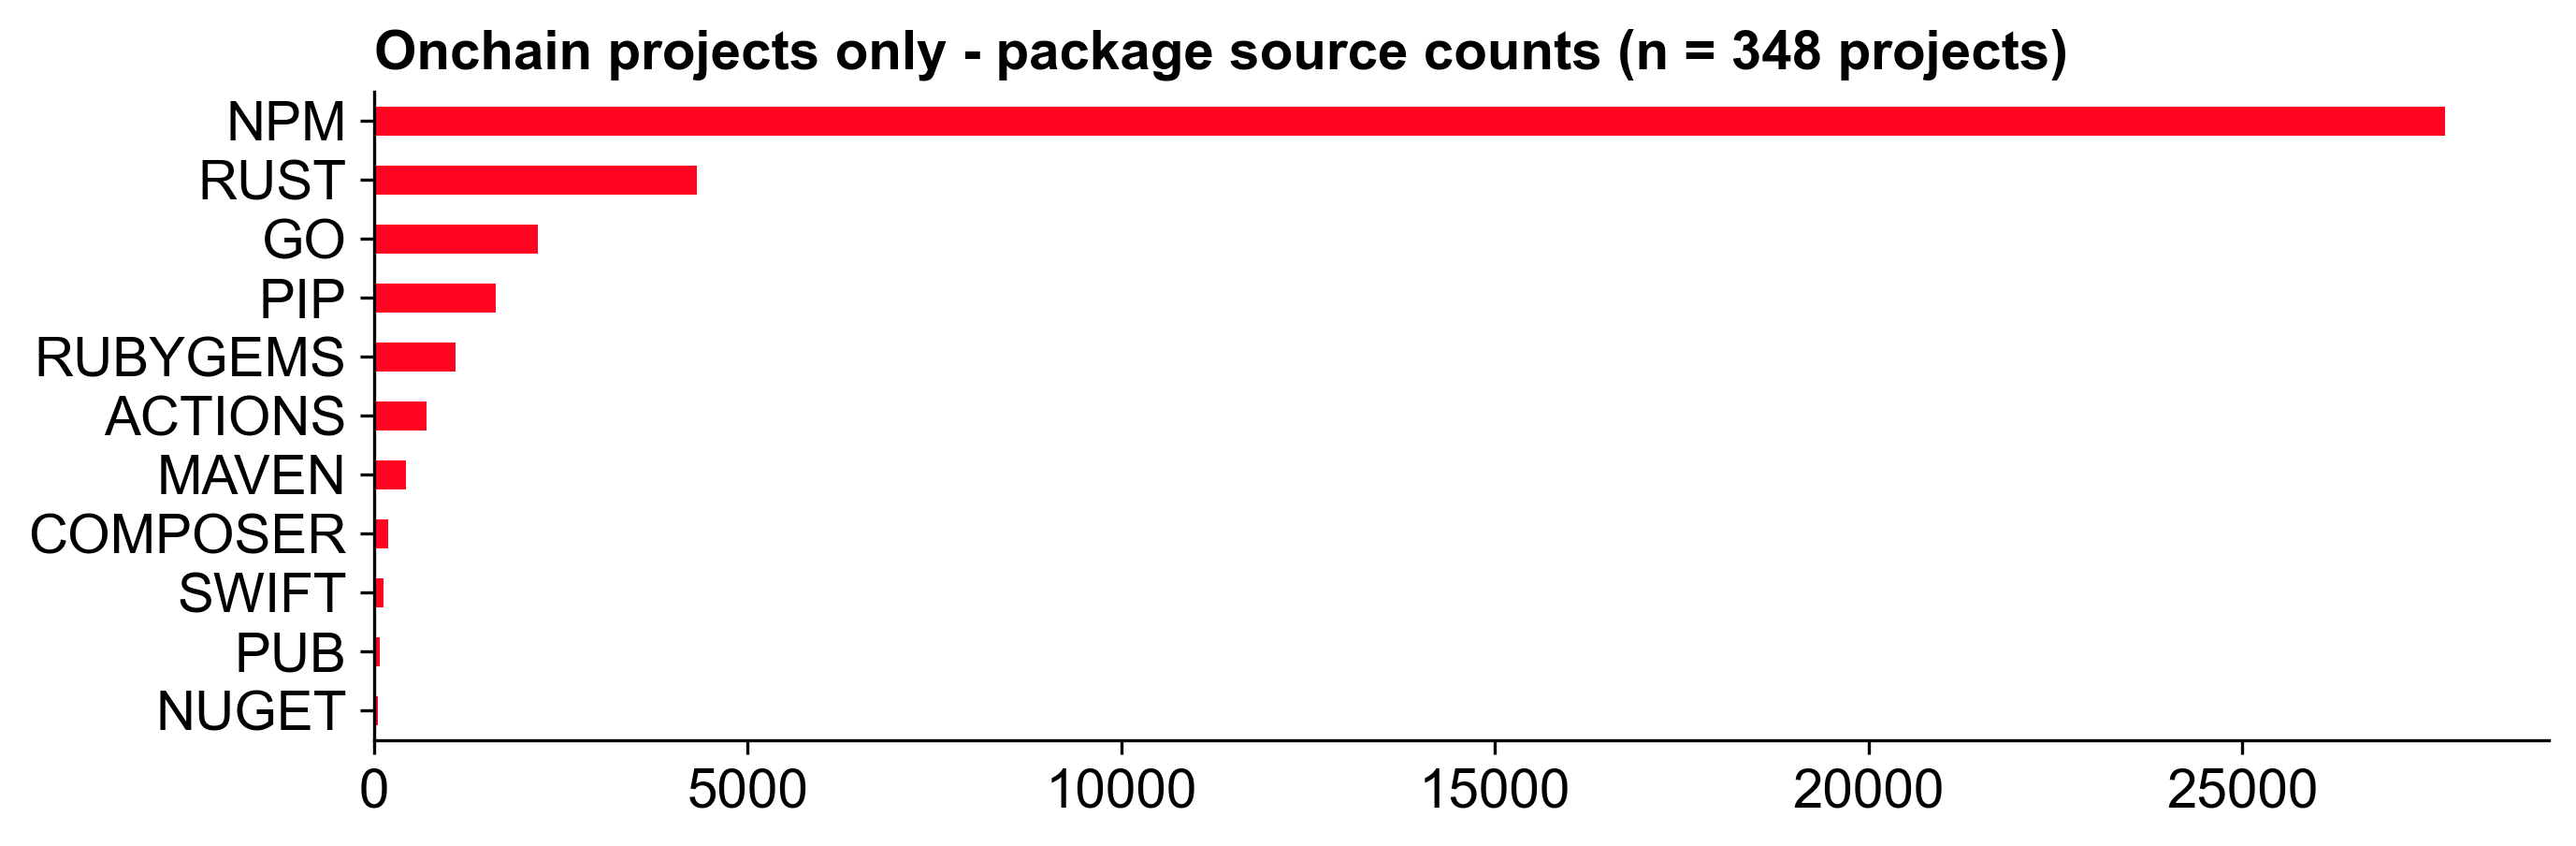

In [10]:
fig, ax = get_plot(
    df_sbom[
        df_sbom['project_name'].isin(onchain_projects)
    ].groupby('package_source')['package']
    .nunique()
    .sort_values(),
    kind='barh',
    color='#FF0420'
)
ax.set_title(f'Onchain projects only - package source counts (n = {len(onchain_projects)} projects)',
             loc='left', weight='bold')
ax.set_ylabel('')

In [11]:
onchain_filter = ((df['op_onchain_project_count'] >= 3) & (df['ratio'] > 1))
dff = df[onchain_filter].sort_values(by='ratio')
dff

,package_source,package,github_org_count,op_project_count,op_onchain_project_count,op_project_share,op_onchain_project_share,ratio
83280,NPM,strip-comments,639,207.0,113.0,0.324451,0.324713,1.000805
84912,NPM,scheduler,1346,414.0,226.0,0.648903,0.649425,1.000805
83050,NPM,react-lifecycles-compat,569,196.0,107.0,0.307210,0.307471,1.000850
83082,NPM,@babel/eslint-parser,586,185.0,101.0,0.289969,0.290230,1.000901
82825,NPM,num2fraction,486,174.0,95.0,0.272727,0.272989,1.000958
...,...,...,...,...,...,...,...,...
61706,NPM,jspm-github,7,4.0,4.0,0.006270,0.011494,1.833333
65278,NPM,@glimmer/util,9,4.0,4.0,0.006270,0.011494,1.833333
61763,NPM,@vanilla-extract/esbuild-plugin,7,4.0,4.0,0.006270,0.011494,1.833333
61522,NPM,@uniswap/token-list-bridge-utils,6,4.0,4.0,0.006270,0.011494,1.833333


Text(0.5, 0, 'Number of onchain dependents')

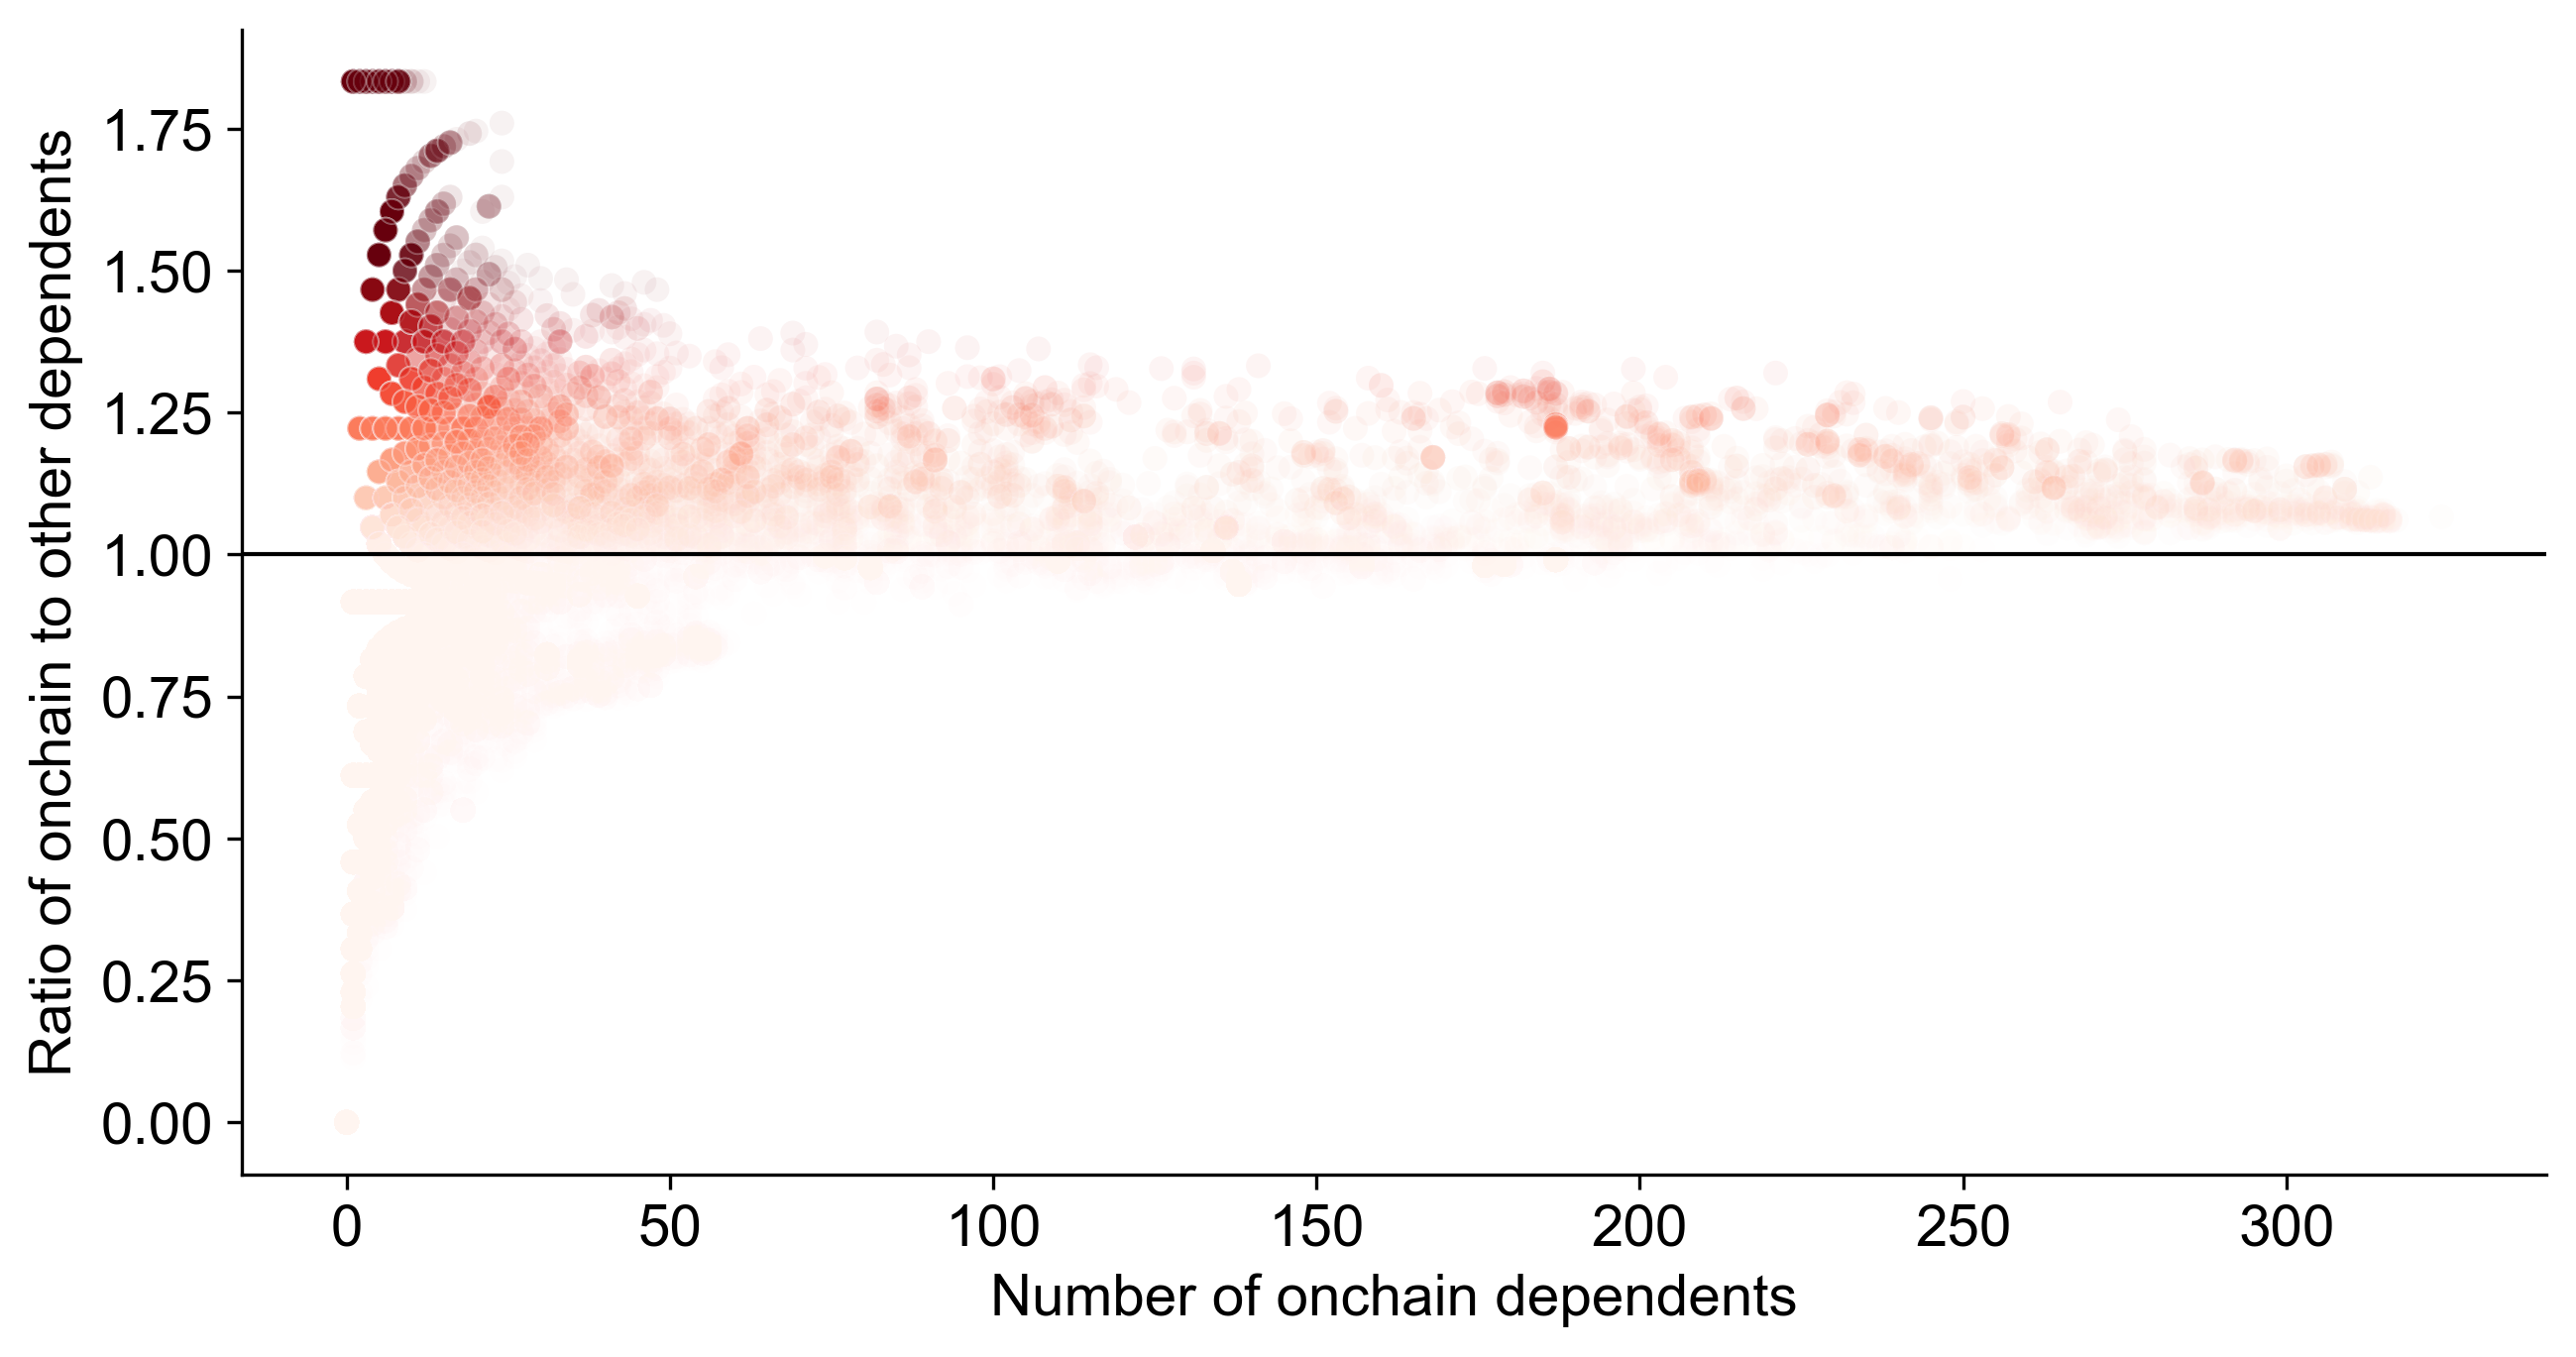

In [12]:
fig, ax = plt.subplots(figsize=(10,5), dpi=300)
sns.scatterplot(
    data=df,
    x='op_onchain_project_count',
    y='ratio',
    alpha=.05,
    hue='ratio',
    palette='Reds',
    hue_norm=(1.0,1.5),
    legend=False,
    ax=ax
)
ax.axhline(1, color='black', lw=1)
ax.set_ylabel('Ratio of onchain to other dependents')
ax.set_xlabel('Number of onchain dependents')
#ax.set_xscale('log')

In [14]:
dff.to_csv('data/op_top_dependencies.csv')